#  Fine-tuning on BERT with IMDb reviews.

In [1]:
# Install the librarys
!pip install sympy==1.12 --quiet
!pip install --upgrade transformers accelerate datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 47.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 which is incompati

In [2]:
# Import all the librarys
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, get_scheduler, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import torch
import evaluate
import numpy as np
from tqdm.auto import tqdm
from accelerate import Accelerator
from torch.optim import AdamW

In [3]:
# Load the IMBd dataset from HuggingFace Datasets
raw_dataset = load_dataset("stanfordnlp/imdb")

# Split the dataset on valid, test and train
dataset_clean = raw_dataset["test"].train_test_split(train_size=0.8, seed=42)
dataset_clean["validation"] = dataset_clean.pop("test")
dataset_clean["test"] = dataset_clean.pop("train")
dataset_clean["train"] = raw_dataset["train"]
dataset_clean

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [4]:
# Tokenize the dataset with "bert-base-uncased"
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(data):
    return tokenizer(data["text"], padding=True, truncation=True, max_length=256, return_tensors="pt")

tokenized_dataset = dataset_clean.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [5]:
# Create the dataloader (Manual training)
train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_dataset["test"], batch_size=8, collate_fn=data_collator
)

valid_dataloader = DataLoader(
    tokenized_dataset["validation"], batch_size=8, collate_fn=data_collator
)

# Let's see if the dataloader works
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 256]),
 'token_type_ids': torch.Size([8, 256]),
 'attention_mask': torch.Size([8, 256])}

In [6]:
# Create the evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"]
    }

In [7]:
# Load the model, the args and the "trainer" object.
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

training_args = TrainingArguments(
    output_dir="test_trainer",
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Train the model with .train()
entrenamiento = trainer.train()
entrenamiento

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.365100,0.320777,0.898600,0.898508
2,0.234400,0.384765,0.906600,0.906478
3,0.120100,0.546423,0.895800,0.895385
4,0.049200,0.590795,0.911600,0.911573
5,0.017200,0.626709,0.912400,0.912399


TrainOutput(global_step=15625, training_loss=0.15720402319335938, metrics={'train_runtime': 1531.6092, 'train_samples_per_second': 81.614, 'train_steps_per_second': 10.202, 'total_flos': 1.644444096e+16, 'train_loss': 0.15720402319335938, 'epoch': 5.0})

In [9]:
# Visualize the final results.
test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
print(f"Resultados finales: {test_results}")

Resultados finales: {'eval_loss': 0.5969551205635071, 'eval_accuracy': 0.9158, 'eval_f1': 0.9157966655347507, 'eval_runtime': 77.933, 'eval_samples_per_second': 256.631, 'eval_steps_per_second': 32.079, 'epoch': 5.0}


## Hagamos entrenamiento manual

In [10]:
# Create the accelerator argument
accelerator = Accelerator()
print(accelerator.device)

# Create model and metrics
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

# Create new variables with the accelerator.prepare
train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, valid_dataloader, model, optimizer
)

num_epochs = 5
patience = 2
num_training_steps = num_epochs * len(train_dl)

lr_scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,
)

# Progress and metrics bar
progress_bar = tqdm(range(num_training_steps))
acc_score = []
f1_score = []
best_accuracy = 0
counter = 0

# Training Loop
model.train()
for epoch in range(num_epochs):
  accuracy = evaluate.load("accuracy")
  f1 = evaluate.load("f1")
  for batch in train_dl:
    outputs = model(**batch)
    loss = outputs.loss
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

  # Evaluation
  model.eval()
  for batch in eval_dl:
    with torch.no_grad():
      outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      accuracy.add_batch(predictions=accelerator.gather(predictions),
                       references=accelerator.gather(batch["labels"]))
      f1.add_batch(predictions=accelerator.gather(predictions),
                       references=accelerator.gather(batch["labels"]))


  acc_result = accuracy.compute()
  f1_result = f1.compute(average="weighted")
  acc_score.append(acc_result)
  f1_score.append(f1_result)
  accuracy_score = acc_result["accuracy"]
  if accuracy_score > best_accuracy:
    best_accuracy = accuracy_score
    counter = 0
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained("best_model")
    tokenizer.save_pretrained("best_model")

  else:
    counter += 1
    if counter > patience:
      print("Early stopping triggered")
      break


  print(f"Epoch: {epoch+1} -> Accuracy: {acc_result['accuracy']:.4f}, F1: {f1_result['f1']:.4f}")
  print("----" * 20)

cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch: 1 -> Accuracy: 0.8964, F1: 0.8959
--------------------------------------------------------------------------------
Epoch: 2 -> Accuracy: 0.9212, F1: 0.9212
--------------------------------------------------------------------------------
Epoch: 3 -> Accuracy: 0.9162, F1: 0.9162
--------------------------------------------------------------------------------
Epoch: 4 -> Accuracy: 0.9198, F1: 0.9198
--------------------------------------------------------------------------------
Early stopping triggered


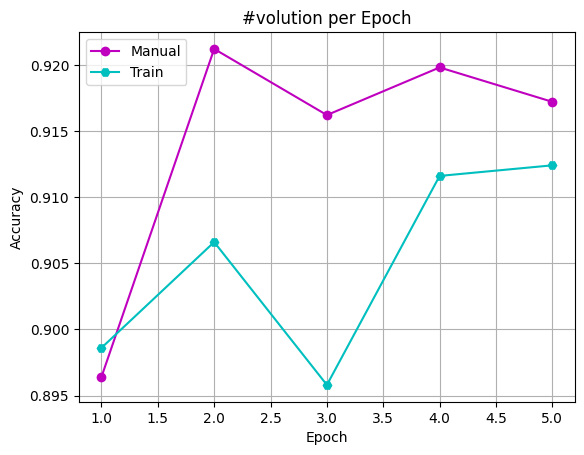

In [14]:
# Visualize the difference between both training loops
acc_manual = [m["accuracy"] for m in acc_score]
acc_train = [0.898600, 0.906600, 0.895800, 0.911600, 0.912400]
plt.plot(range(1, num_epochs+1), acc_manual, marker='o', c="m")
plt.plot(range(1, num_epochs+1), acc_train, marker='H', c="c")
plt.title("#volution per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Manual", "Train"])
plt.grid()
plt.show()

In [16]:
# Charge the best model and compare the results.
model.eval()
test_dl = accelerator.prepare(test_dataloader)
test_accuracy = evaluate.load("accuracy")
test_f1 = evaluate.load("f1")
test_loss = []

for batch in test_dl:
    with torch.no_grad():
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        test_loss.append(outputs.loss.item())
        test_accuracy.add_batch(predictions=accelerator.gather(predictions),
                                references=accelerator.gather(batch["labels"]))
        test_f1.add_batch(predictions=accelerator.gather(predictions),
                          references=accelerator.gather(batch["labels"]))

print("Manual Model Test Set Results:")
print(f"Accuracy: {test_accuracy.compute()['accuracy']:.3f}")
print(f"F1 score: {test_f1.compute(average='weighted')['f1']:.3f}")
print(f"Loss: {(test_loss[-1]):.3f}")

print("Trainer Model Test Set Results:")
print(f"Accuracy: {test_results['eval_accuracy']:.3f}")
print(f"F1 score: {test_results['eval_f1']:.3f}")
print(f"Loss: {test_results['eval_loss']:.3f}")

Manual Model Test Set Results:
Accuracy: 0.921
F1 score: 0.921
Loss: 1.164
Trainer Model Test Set Results:
Accuracy: 0.916
F1 score: 0.916
Loss: 0.597
